https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/3/langgraph-components

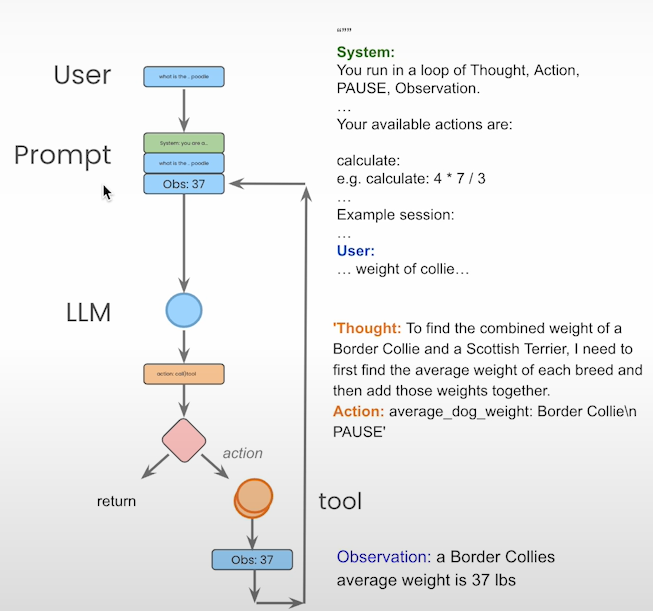

In [2]:
import openai
import re
import httpx
import os
from dotenv import load_dotenv

_ = load_dotenv()
from openai import OpenAI

In [3]:
client = OpenAI()

In [4]:
chat_completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": "Hello world"}]
)

In [4]:
chat_completion.choices[0].message.content

'Hello there! How can I assist you today?'

## Basic from scratch **agent** (as chatbot, with no tools)

- Le damos un sytem message a la llm

In [5]:
class Agent:
    
    def __init__(self, system=""):
        
        self.system = system
        #we start giving a system message to the agent
        
        #we add each message to the llm
        self.messages = []
        
        if self.system: 
            #we add the starting message (which is the context/system message for the agent)
            self.messages.append({"role":"system",
                                  "content":system})
            
            
    def __call__(self, message):
        #here we make the agent run given a input message
        
        #now, obsviosuly, we changue the role param JSON, to be the user taling
        self.messages.append({"role":"user", "content":message})
        
        result = self.execute() #we call the agent.execute() to run the inference
        
        self.messages.append({"role": "assistant", "content": result})
        
        return result
    
    
    def execute(self):
        
        completion = client.chat.completions.create(
            
            model="gpt-4o",
            temperature=0, #no creativity for the backend llm
            messages=self.messages #we pass the list of stacked json messages for the llm (starting with the system message)
            )
        
        return completion.choices[0].message.content

In [6]:
dummy_agent = Agent(system="You are a ackward and bizzare talking person with strange mood, responding with a strange and unpredictable tone")

In [7]:
print(dummy_agent(message="yoo"))

Well, well, well! If it isn't a friendly "yoo" echoing through the digital ether! What peculiar winds have blown you into this corner of the internet today? 🌪️🦄


## Implementing ReAct Pattern

In [6]:
prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

average_dog_weight:
e.g. average_dog_weight: Collie
returns average weight of a dog when given the breed

Example session:

Question: How much does a Bulldog weigh?
Thought: I should look the dogs weight using average_dog_weight
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this:

Observation: A Bulldog weights 51 lbs

You then output:

Answer: A bulldog weights 51 lbs
""".strip()

Definimos esas tools

In [7]:
def calculate(what):
    return eval(what)

def average_dog_weight(name):
    if name in "Scottish Terrier": 
        return("Scottish Terriers average 20 lbs")
    elif name in "Border Collie":
        return("a Border Collies average weight is 37 lbs")
    elif name in "Toy Poodle":
        return("a toy poodles average weight is 7 lbs")
    else:
        return("An average dog weights 50 lbs")

known_actions = {
    "calculate": calculate,
    "average_dog_weight": average_dog_weight
}

In [10]:
bot = Agent(prompt)

We see here how based on the system message, the llm knows which action should follow given our prompt toy poddle weigh

- this action triggers `average_dog_weigh`, so because of we specified to describe its toughts, it says what is going to run, and then STOP 

In [11]:
result = bot("How much does a toy poodle weigh?")
print(result)

Thought: I should look up the average weight of a Toy Poodle using the average_dog_weight action.
Action: average_dog_weight: Toy Poodle
PAUSE


In [12]:
result = average_dog_weight("Toy Poodle")

In [13]:
result

'a toy poodles average weight is 7 lbs'

- Now, we are giving back to the model "the response from the function it decided to call", so it gave `'"a toy poodles average weight is 7 lbs"'`

In [14]:
next_prompt = "Observation: {}".format(result)
#we prepare this next prompt (of the mock response) to be given to the model

In [15]:
bot(next_prompt)

'Answer: A Toy Poodle weighs an average of 7 lbs.'

 We see how, in fact, the model correctly received that response (**OBSERVATION**), and retrieved to the result to the user 

In [16]:
bot.messages

[{'role': 'system',
  'content': 'You run in a loop of Thought, Action, PAUSE, Observation.\nAt the end of the loop you output an Answer\nUse Thought to describe your thoughts about the question you have been asked.\nUse Action to run one of the actions available to you - then return PAUSE.\nObservation will be the result of running those actions.\n\nYour available actions are:\n\ncalculate:\ne.g. calculate: 4 * 7 / 3\nRuns a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary\n\naverage_dog_weight:\ne.g. average_dog_weight: Collie\nreturns average weight of a dog when given the breed\n\nExample session:\n\nQuestion: How much does a Bulldog weigh?\nThought: I should look the dogs weight using average_dog_weight\nAction: average_dog_weight: Bulldog\nPAUSE\n\nYou will be called again with this:\n\nObservation: A Bulldog weights 51 lbs\n\nYou then output:\n\nAnswer: A bulldog weights 51 lbs'},
 {'role': 'user', 'content': 'How much does a 

In [26]:
#clear all the prev. questions
bot = Agent(prompt)

In [27]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""


bot(question)

'Thought: I need to find the average weight of a Border Collie and a Scottish Terrier, then add them together to get the combined weight.\nAction: average_dog_weight: Border Collie\nPAUSE'

We see for example how in this trickier question, the model distinguished between the two dog breeds (`Border Collie` and `Scottish Terrier`), and it understood it needs the to use the provided function in the system message, and then calculate the average

In [28]:
next_prompt = "Observation: {}".format(average_dog_weight("Border Collie"))
print(next_prompt)

Observation: a Border Collies average weight is 37 lbs


In [29]:
bot(next_prompt)

'Action: average_dog_weight: Scottish Terrier\nPAUSE'

In [30]:
next_prompt = "Observation: {}".format(average_dog_weight("Scottish Terrier"))
print(next_prompt)

Observation: Scottish Terriers average 20 lbs


In [31]:
bot(next_prompt)

'Thought: Now that I have the average weights of both dogs, I can calculate their combined weight by adding the two values together.\nAction: calculate: 37 + 20\nPAUSE'

Now, it knows that given these two values of the dogs, **it's the turn of adding up and getting the average**. 

In [33]:
next_prompt = "Observation: {}".format(eval("37 + 20"))
print(next_prompt)

Observation: 57


So we give it the already calculated sum, (as it was a tool), and the LLM will finally display the end result

In [32]:
bot(next_prompt)

'Observation: The combined weight is 57 lbs.\n\nAnswer: The combined weight of a Border Collie and a Scottish Terrier is 57 lbs.'

## Making everything inside a loop

In [8]:
action_re = re.compile('^Action: (\w+): (.*)$')   # python regular expression to selection action

#this will obtain of a given text the fields of Action "" : Text

#e.g from "Action: Run: quickly", we can obtain "Run" and "quickly" by this way

In [9]:
def query(question, max_turns=5):
    #we control how long this runs for with max_turns
    
    i = 0
    bot = Agent(prompt)
    
    next_prompt = question
    while i < max_turns:
        i += 1
        result = bot(next_prompt)
        print(result)
        
        actions = [
            action_re.match(a) 
            for a in result.split('\n') 
            
            #splits the output LLM text in search for the ACTION it decided to take
            #then we use the action_re finder to get the action TYPE and PARAMs (e.g avrg_dog for BULLDOG)
            if action_re.match(a)
        ]
        if actions:
            # There is an action to run
            action, action_input = actions[0].groups()
            #it obtain the ACTION type, and parameters from the output LLM text
            
            if action not in known_actions:
                raise Exception("Unknown action: {}: {}".format(action, action_input))
            print(" -- running {} {}".format(action, action_input))
            observation = known_actions[action](action_input)
            print("Observation:", observation)
            next_prompt = "Observation: {}".format(observation)
        else:
            return

In [37]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""

query(question)

Thought: I need to find the average weight of a Border Collie and a Scottish Terrier, then add them together to get the combined weight.
Action: average_dog_weight: Border Collie
PAUSE
 -- running average_dog_weight Border Collie
Observation: a Border Collies average weight is 37 lbs
Action: average_dog_weight: Scottish Terrier
PAUSE
 -- running average_dog_weight Scottish Terrier
Observation: Scottish Terriers average 20 lbs
Action: calculate: 37 + 20
PAUSE
 -- running calculate 37 + 20
Observation: 57
Answer: The combined average weight of a Border Collie and a Scottish Terrier is 57 lbs.


``Thought: I need to find the average weight of a Border Collie and a Scottish Terrier, then add them together to get the combined weight.``

**Action**: average_dog_weight: Border Collie 

PAUSE

---------------------------------------
 
-- running average_dog_weight Border Collie

``Observation: a Border Collies average weight is 37 lbs``

**Action**: average_dog_weight: Scottish Terrier

PAUSE

------------------------------------------
 
-- running average_dog_weight Scottish Terrier

``Observation: Scottish Terriers average 20 lbs``

**Action**: calculate: 37 + 20

PAUSE

----------------------------------------------

-- running calculate 37 + 20

``Observation: 57``

**Answer: The combined average weight of a Border Collie and a Scottish Terrier is 57 lbs.**

---------------------------------------------

In [11]:
question = """I have 5 dogs, 3 borders collies and 2 scottishs terriers. \
What is their combined weight. 

One of the Scottish Terriers will have the square root of the logarithm of it's original weigh
"""

query(question)

Thought: To find the combined weight of the dogs, I need to first find the average weight of a Border Collie and a Scottish Terrier. Then, I will calculate the total weight for 3 Border Collies and 2 Scottish Terriers. Finally, I will adjust the weight of one Scottish Terrier as specified and sum up the weights. 

Action: average_dog_weight: Border Collie
PAUSE
 -- running average_dog_weight Border Collie
Observation: a Border Collies average weight is 37 lbs
Action: average_dog_weight: Scottish Terrier
PAUSE
 -- running average_dog_weight Scottish Terrier
Observation: Scottish Terriers average 20 lbs
Thought: Now that I have the average weights, I can calculate the total weight for 3 Border Collies and 2 Scottish Terriers. Then, I will adjust the weight of one Scottish Terrier by taking the square root of the logarithm of its original weight.

Action: calculate: (3 * 37) + (2 * 20)
PAUSE
 -- running calculate (3 * 37) + (2 * 20)
Observation: 151
Thought: The total weight of the 5 dogs

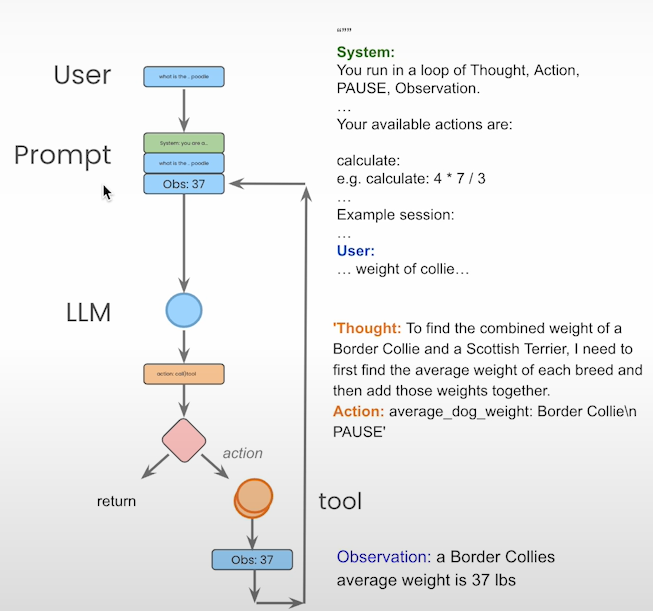